In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [22]:
# https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
# https://github.com/thatsmellything/cs5830_project8
df = pd.read_csv('weatherAUS.csv')

binary = ['RainToday', 'RainTomorrow']
direction = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
categorical = ['Location']
numerical = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'Evaporation', 'Sunshine', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
date = ['Date'] 

windDir = {
    'N': 0, 'NNE': 22.5, 'NE': 45,
    'ENE': 67.5, 'E': 90, 'ESE': 112.5,
    'SE': 135, 'SSE': 157.5, 'S': 180, 'SSW': 202.5, 'SW': 225,
    'WSW': 247.5, 'W': 270, 'WNW': 292.5,
    'NW': 315, 'NNW': 337.5
}
def circleEncoding(direction):
    if (direction not in windDir):
        return (0, 0)
    num = windDir[direction]
    angle = np.deg2rad(num)
    return round(np.cos(angle), 3), round(np.sin(angle), 3)

columns = set(df.columns.values)
print(f"are all the columns in the dataframe: {columns == set(categorical + numerical + date)}")
print(f"columns that are not in the dataframe: {columns - set(categorical + numerical + date)}")


are all the columns in the dataframe: False
columns that are not in the dataframe: {'RainTomorrow', 'RainToday', 'WindDir9am', 'WindDir3pm', 'WindGustDir'}


In [23]:
""" Standardize the numerical columns and one-hot encode the categorical columns.
    convert the binary columns to 0 and 1. And convert the date column to datetime."""

scaler = StandardScaler()
df[numerical] = scaler.fit_transform(df[numerical])
df[numerical] = df[numerical].fillna(0)
df[numerical] = df[numerical].astype('float16')

df[binary] = df[binary].replace({'No': 0, 'Yes': 1})

# df = pd.get_dummies(df, columns=categorical)
df = df.drop(columns=categorical)

df['Date'] = pd.to_datetime(df['Date']).dt.month
df = df.rename(columns={'Date': 'Month'})

for col in direction: # Apply circle encoding and return the sin and cos values into features
    df[col + '_cos'], df[col + '_sin'] = zip(*df[col].apply(circleEncoding))
df = df.drop(columns=direction)

df = df.dropna()

# Assuming 'df' is your DataFrame containing the dataset
print(f"Classes: {df['RainToday'].value_counts()}")

# Apply SMOTE to class 1 (RainTomorrow) to balance the classes
smote = SMOTE(sampling_strategy={1: 50000})
X = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']
X, y = smote.fit_resample(X, y)

# Apply random undersampling to the majority class (class 0)
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Concatenate the downsampled data into a new DataFrame
df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='RainTomorrow')], axis=1)

print(f"Classes after SMOTE and random undersampling: {df['RainTomorrow'].value_counts()}")

df.to_csv('weatherAUS_cleaned.csv', index=False)

Classes: RainToday
0.0    109332
1.0     31455
Name: count, dtype: int64
Classes after SMOTE and random undersampling: RainTomorrow
0.0    50000
1.0    50000
Name: count, dtype: int64


In [24]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.initializers import HeNormal
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.optimizers.schedules import ExponentialDecay
from keras.layers import Dropout
from sklearn.base import BaseEstimator, ClassifierMixin


class DenseModel(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = Sequential([
            self.DenseLayer(2, activation='relu'),
            Dropout(0.2),
            self.DenseLayer(1, activation='sigmoid'),
        ])
    
    # Customer Dense layer
    def DenseLayer(self, nodes, activation='relu'):
        return Dense(
            nodes, activation=activation, 
            kernel_initializer=HeNormal(), bias_initializer=HeNormal(),
            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
        )

    # Resets weights to HeNormal
    def reset_weights(self):
        initial_weights = self.model.get_weights()
        self.model.set_weights(initial_weights)

    # compile the model
    def compile(self):
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Run the model. Forward fit using a learning rate scheduler
    def fit(self, training_images, training_labels, epochs=1, batch_size=32):
        lr_scheduler = ExponentialDecay(initial_learning_rate=0.001, decay_steps=1, decay_rate=.8)
        self.model.fit(training_images, training_labels, epochs=epochs, 
                    batch_size=batch_size, callbacks=[LearningRateScheduler(lr_scheduler)])


Epoch 1/6
2500/2500 [==============================] - 2s 609us/step - loss: 0.7344 - accuracy: 0.6843 - lr: 0.0010
Epoch 2/6
2500/2500 [==============================] - 1s 556us/step - loss: 0.5568 - accuracy: 0.7206 - lr: 8.0000e-04
Epoch 3/6
2500/2500 [==============================] - 1s 534us/step - loss: 0.5448 - accuracy: 0.7191 - lr: 6.4000e-04
Epoch 4/6
2500/2500 [==============================] - 1s 557us/step - loss: 0.5418 - accuracy: 0.7197 - lr: 5.1200e-04
Epoch 5/6
2500/2500 [==============================] - 1s 538us/step - loss: 0.5423 - accuracy: 0.7183 - lr: 4.0960e-04
Epoch 6/6
625/625 [==============================] - 0s 409us/step


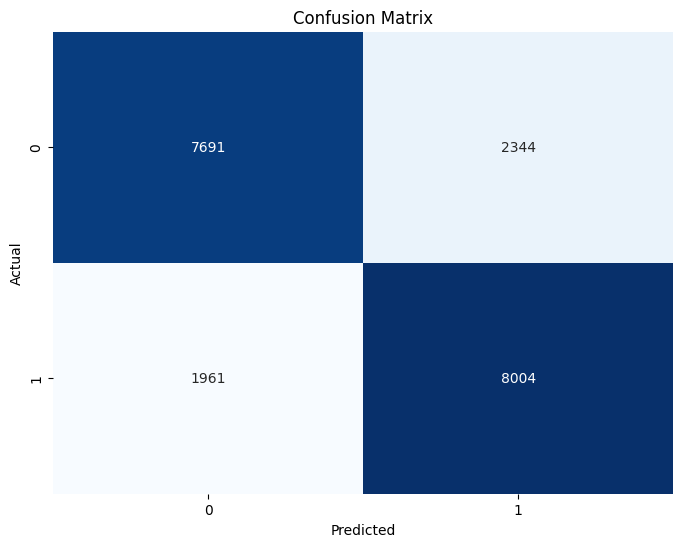

F1 Score: 0.78806675527987
Accuracy: 0.78475


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
y = df['RainTomorrow']
X = df.drop(columns=['RainTomorrow'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train the model
model = DenseModel()
model.compile()
model.fit(X_train, y_train, epochs=6, batch_size=32)

# Evaluate the model on the test set
y_pred = model.model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate evaluation metrics and confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display F1 score and accuracy
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')

